<a href="https://colab.research.google.com/github/B21-CAP0075/Dementia-Classification/blob/development/cdr_binary_classification_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=aa2ce17cc73617cd63bfd04f12301791fc2bd141aed03418f62ae85c730c7456
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! kaggle datasets download -d jboysen/mri-and-alzheimers

  0% 0.00/12.6k [00:00<?, ?B/s]
100% 12.6k/12.6k [00:00<00:00, 12.1MB/s]


In [5]:
zip_ref = zipfile.ZipFile('mri-and-alzheimers.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
df_cross = pd.read_csv('oasis_cross-sectional.csv')
print(len(df_cross))
print(df_cross[df_cross['CDR'] >= 1].groupby('Educ').size())

436
Educ
1.0     7
2.0    11
3.0     4
4.0     5
5.0     3
dtype: int64


In [7]:
df_long = pd.read_csv('oasis_longitudinal.csv')
print(len(df_long))
print(df_long.groupby('EDUC').size())

373
EDUC
6       3
8       9
11     11
12    103
13     27
14     33
15     17
16     81
17      9
18     64
20     13
23      3
dtype: int64


In [8]:
df_cross = df_cross.drop(columns=['ID', 'Delay', 'Hand', 'eTIV', 'nWBV', 'ASF'])
df_cross.columns = ['M/F', 'Age',	'EDUC',	'SES',	'MMSE',	'CDR']
df_cross.head()

,M/F,Age,EDUC,SES,MMSE,CDR
0,F,74,2.0,3.0,29.0,0.0
1,F,55,4.0,1.0,29.0,0.0
2,F,73,4.0,3.0,27.0,0.5
3,M,28,NaN,NaN,NaN,NaN
4,M,18,NaN,NaN,NaN,NaN


In [9]:
df_long = df_long.drop(columns=['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand', 'eTIV', 'nWBV', 'ASF', 'Group'])
df_long.head()

,M/F,Age,EDUC,SES,MMSE,CDR
0,M,87,14,2.0,27.0,0.0
1,M,88,14,2.0,30.0,0.0
2,M,75,12,NaN,23.0,0.5
3,M,76,12,NaN,28.0,0.5
4,M,80,12,NaN,22.0,0.5


In [10]:
df_cross.loc[df_cross.EDUC == 1.0, 'EDUC'] =  6
df_cross.loc[df_cross.EDUC == 2.0, 'EDUC'] =  12
df_cross.loc[df_cross.EDUC == 3.0, 'EDUC'] =  15
df_cross.loc[df_cross.EDUC == 4.0, 'EDUC'] =  16
df_cross.loc[df_cross.EDUC == 5.0, 'EDUC'] =  23

In [11]:
df_cross_dementia = df_cross[df_cross['CDR'] >= 1]
print(len(df_cross_dementia))
print(df_cross_dementia['CDR'].unique())
print(df_cross_dementia['EDUC'].unique())
df_cross_dementia.head()

30
[1. 2.]
[12.  6. 15. 16. 23.]


,M/F,Age,EDUC,SES,MMSE,CDR
25,F,86,12.0,4.0,27.0,1.0
28,M,88,6.0,4.0,26.0,1.0
32,F,84,15.0,2.0,28.0,1.0
47,F,78,6.0,5.0,23.0,1.0
48,F,83,6.0,4.0,21.0,1.0


In [12]:
df = pd.concat([df_long, df_cross_dementia])
df = df[df['CDR'].notna()]
df

,M/F,Age,EDUC,SES,MMSE,CDR
0,M,87,14.0,2.0,27.0,0.0
1,M,88,14.0,2.0,30.0,0.0
2,M,75,12.0,NaN,23.0,0.5
3,M,76,12.0,NaN,28.0,0.5
4,M,80,12.0,NaN,22.0,0.5
...,...,...,...,...,...,...
367,M,77,23.0,1.0,23.0,1.0
384,M,75,16.0,1.0,20.0,1.0
385,F,78,6.0,4.0,23.0,1.0
389,M,71,16.0,1.0,17.0,1.0


In [13]:
df['CDR'] = df['CDR'].replace(
    [0.0, 0.5, 1.0, 2.0],
    [0, 0, 1, 1]
)
print(df['CDR'].unique())

[0. 1.]


In [14]:
df_temp = df[df['CDR'] == 0]
df_temp = df_temp[:len(df[df['CDR'] == 0])]
new_df = df_temp.append(df[df['CDR'] == 1])

df = new_df
print(len(df))
print(df.groupby('EDUC').size())

403
EDUC
6.0      10
8.0       9
11.0     11
12.0    114
13.0     27
14.0     33
15.0     21
16.0     86
17.0      9
18.0     64
20.0     13
23.0      6
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


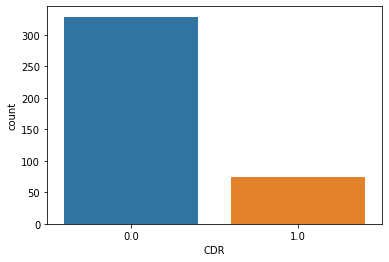

In [15]:
sns.countplot(df['CDR'])

In [16]:
df.isnull().sum()

M/F      0
Age      0
EDUC     0
SES     23
MMSE     2
CDR      0
dtype: int64

In [17]:
mean_ses = df['SES'].mean()
mean_mmse = df['MMSE'].mean()

print(round(mean_ses))
print(round(mean_mmse))

2
27


In [18]:
df['SES'].fillna(round(mean_ses), inplace=True)
df['MMSE'].fillna(round(mean_mmse), inplace=True)
df.isnull().sum()

M/F     0
Age     0
EDUC    0
SES     0
MMSE    0
CDR     0
dtype: int64

In [19]:
gender = pd.get_dummies(df['M/F'])

df = df.drop(columns=['M/F'])
df = pd.concat([df, gender], axis=1)
df

,Age,EDUC,SES,MMSE,CDR,F,M
0,87,14.0,2.0,27.0,0.0,0,1
1,88,14.0,2.0,30.0,0.0,0,1
2,75,12.0,2.0,23.0,0.0,0,1
3,76,12.0,2.0,28.0,0.0,0,1
4,80,12.0,2.0,22.0,0.0,0,1
...,...,...,...,...,...,...,...
367,77,23.0,1.0,23.0,1.0,0,1
384,75,16.0,1.0,20.0,1.0,0,1
385,78,6.0,4.0,23.0,1.0,1,0
389,71,16.0,1.0,17.0,1.0,0,1


In [20]:
df_normal = df[df['CDR'] == 0]
df_dementia = df[df['CDR'] == 1]

print(df_normal.tail())
print(df_dementia.tail())
print()
print(len(df_normal))
print(len(df_dementia))

     Age  EDUC  SES  MMSE  CDR  F  M
368   82  16.0  1.0  28.0  0.0  0  1
369   86  16.0  1.0  26.0  0.0  0  1
370   61  13.0  2.0  30.0  0.0  1  0
371   63  13.0  2.0  30.0  0.0  1  0
372   65  13.0  2.0  30.0  0.0  1  0
     Age  EDUC  SES  MMSE  CDR  F  M
367   77  23.0  1.0  23.0  1.0  0  1
384   75  16.0  1.0  20.0  1.0  0  1
385   78   6.0  4.0  23.0  1.0  1  0
389   71  16.0  1.0  17.0  1.0  0  1
410   75   6.0  4.0  22.0  1.0  0  1

329
74


In [21]:
x_normal = df_normal[['Age', 'EDUC', 'SES', 'MMSE', 'F',	'M']].values
y_normal = df_normal[['CDR']].values

x_dementia = df_dementia[['Age', 'EDUC', 'SES', 'MMSE', 'F',	'M']].values
y_dementia = df_dementia[['CDR']].values

In [22]:
split = 0.2
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x_normal, y_normal, test_size=split, random_state=42)
x_train_dementia, x_test_dementia, y_train_dementia, y_test_dementia = train_test_split(x_dementia, y_dementia, test_size=split, random_state=42)

print(len(x_test_normal))
print(len(x_test_dementia))

66
15


In [23]:
x_train = (x_train_normal, x_train_dementia)
x_test = (x_test_normal, x_test_dementia)
y_train = (y_train_normal, y_train_dementia)
y_test = (y_test_normal, y_test_dementia)

In [24]:
x_train, x_test, y_train, y_test = np.concatenate(x_train), np.concatenate(x_test), np.concatenate(y_train), np.concatenate(y_test)

In [25]:
print(x_train.shape)
print(x_test.shape)

(322, 6)
(81, 6)


In [26]:
scaler = MinMaxScaler().fit(np.concatenate((x_train, x_test)))
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [27]:
# save feature numpy as scaler at backend
np.savetxt("scaler.csv", np.concatenate((x_train, x_test)), delimiter=",")

In [28]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(16, activation='relu', input_shape=[6]),
                             tf.keras.layers.Dense(8, activation='relu'),
                             tf.keras.layers.Dense(4, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')    
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [29]:
class StopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    accuracy = 0.90
    loss = 0.28
    if(logs.get('accuracy') >= accuracy and logs.get('val_accuracy') >= accuracy and
       logs.get('loss') <= loss and logs.get('val_loss') <= loss):
      print('\nSudah mencapai akurasi {}%, proses training berhenti'.format(accuracy*100))
      self.model.stop_training = True

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=100)
st = StopTraining()

In [30]:
history = model.fit(x_train_scaled, y_train, epochs=500, validation_data=(x_test_scaled, y_test), callbacks=[mc, es, st], verbose=2)

Epoch 1/500
11/11 - 4s - loss: 0.7133 - accuracy: 0.2112 - val_loss: 0.6941 - val_accuracy: 0.5062
Epoch 2/500
11/11 - 0s - loss: 0.6835 - accuracy: 0.6366 - val_loss: 0.6655 - val_accuracy: 0.8272
Epoch 3/500
11/11 - 0s - loss: 0.6605 - accuracy: 0.8137 - val_loss: 0.6462 - val_accuracy: 0.8148
Epoch 4/500
11/11 - 0s - loss: 0.6418 - accuracy: 0.8168 - val_loss: 0.6284 - val_accuracy: 0.8148
Epoch 5/500
11/11 - 0s - loss: 0.6246 - accuracy: 0.8168 - val_loss: 0.6114 - val_accuracy: 0.8148
Epoch 6/500
11/11 - 0s - loss: 0.6089 - accuracy: 0.8168 - val_loss: 0.5965 - val_accuracy: 0.8148
Epoch 7/500
11/11 - 0s - loss: 0.5944 - accuracy: 0.8168 - val_loss: 0.5817 - val_accuracy: 0.8148
Epoch 8/500
11/11 - 0s - loss: 0.5800 - accuracy: 0.8168 - val_loss: 0.5658 - val_accuracy: 0.8148
Epoch 9/500
11/11 - 0s - loss: 0.5640 - accuracy: 0.8168 - val_loss: 0.5505 - val_accuracy: 0.8148
Epoch 10/500
11/11 - 0s - loss: 0.5489 - accuracy: 0.8168 - val_loss: 0.5331 - val_accuracy: 0.8148
Epoch 11/

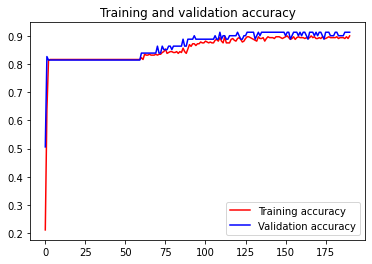

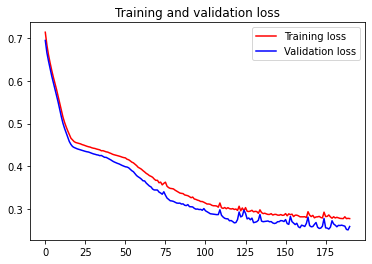

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [32]:
saved_model = load_model('best_model.h5')

loss, acc = saved_model.evaluate(x_test_scaled, y_test)
print("Accuracy: ", acc)
print("Loss: ", loss)

3/3 [==============================] - 0s 4ms/step - loss: 0.2520 - accuracy: 0.9136
Accuracy:  0.9135802388191223
Loss:  0.25200799107551575


In [33]:
normal = [[82,  16.0,  1.0,  28.0,  0,  1],
          [63,  13.0,  2.0,  27.0,  1,  0],
          [60,  18.0,  3.0,  25.0,  1,  0]]

dementia = [[77,  23.0,  3.0,  22.0,  0,  1],
            [78,  6.0,  4.0,  23.0,  1,  0],
            [75,  16.0,  4.0,  21.0,  1,  0]] 

In [34]:
for row in normal:
  classes = model.predict(scaler.transform([row]))

  print(row)
  print(classes)
  if classes[0] < 0.5:
    print("Normal")
  else:
    print("Dementia")
  
  print()

[82, 16.0, 1.0, 28.0, 0, 1]
[[0.0774715]]
Normal

[63, 13.0, 2.0, 27.0, 1, 0]
[[0.06318179]]
Normal

[60, 18.0, 3.0, 25.0, 1, 0]
[[0.2227974]]
Normal



In [35]:
for row in dementia:
  classes = model.predict(scaler.transform([row]))

  print(row)
  print(classes)
  if classes[0] < 0.5:
    print("Normal")
  else:
    print("Dementia")
  
  print()

[77, 23.0, 3.0, 22.0, 0, 1]
[[0.696064]]
Dementia

[78, 6.0, 4.0, 23.0, 1, 0]
[[0.5899219]]
Dementia

[75, 16.0, 4.0, 21.0, 1, 0]
[[0.7843354]]
Dementia

